## Assessing Market Inefficiency Based on Volatility

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display
from openbb import obb
from scipy.stats import spearmanr

In [36]:
obb.user.preferences.output_type = "dataframe"

Define the stock symbols

In [37]:
symbols = ["RELIANCE.NS", "TCS.NS", "HDFCBANK.NS", "VEDL.NS", "ICICIBANK.NS", "AXISBANK.NS", "TRENT.NS", "WIPRO.NS"]

In [38]:
data = obb.equity.price.historical(
    symbols, start_date="2015-01-01", end_date="2025-12-31", provider="yfinance"
)

Select relevant columns from the data

In [39]:
prices = data[["high", "low", "close", "volume", "symbol"]]

Filter out symbols with less than 2 years of data

In [40]:
nobs = prices.groupby("symbol").size()
mask = nobs[nobs > 2 * 12 * 21].index
prices = prices[prices.symbol.isin(mask)]

Reorder levels and sort index

In [41]:
prices = (
    prices.set_index("symbol", append=True)
    .reorder_levels(["symbol", "date"])
    .sort_index(level=0)
).drop_duplicates()

Define a function to calculate Parkinson volatility

In [42]:
def parkinson(data, window=14, trading_days=252):
    rs = (1.0 / (4.0 * np.log(2.0))) * ((data.high / data.low).apply(np.log)) ** 2.0

    def f(v):
        return (trading_days * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    return result.sub(result.mean()).div(result.std())

Calculate volatility using the Parkinson method and add it to the 'prices' DataFrame

In [43]:
prices["vol"] = prices.groupby("symbol", group_keys=False).apply(parkinson)
prices.dropna(inplace=True)

Calculate lagged returns and targets for different time periods

In [44]:
lags = [1, 5, 10, 21, 42, 63]
for lag in lags:
    prices[f"return_{lag}d"] = prices.groupby(level="symbol").close.pct_change(lag)

In [45]:
for t in [1, 5, 10, 21, 42, 63]:
    prices[f"target_{t}d"] = prices.groupby(level="symbol")[f"return_{t}d"].shift(-t)

In [46]:
display(prices)

high         low       close      volume  \
symbol      date                                                         
AXISBANK.NS 2015-01-20  554.700012  531.099976  551.400024   6934581.0   
            2015-01-21  556.799988  545.549988  547.250000   4459351.0   
            2015-01-22  567.150024  547.799988  564.750000   5546866.0   
            2015-01-23  577.400024  560.299988  565.150024   4975114.0   
            2015-01-27  597.799988  567.000000  592.099976   5376830.0   
...                            ...         ...         ...         ...   
WIPRO.NS    2025-02-05  321.450012  314.899994  317.100006   9628027.0   
            2025-02-06  323.600006  314.549988  317.950012  15062390.0   
            2025-02-07  319.000000  314.000000  318.000000   8589587.0   
            2025-02-10  321.000000  315.850006  319.049988  12304840.0   
            2025-02-11  320.399994  311.600006  313.000000  10627295.0   

                             vol  return_1d  return_5d  return_10d  \
symbol      date                                                     
AXISBANK.NS 2015-01-20 -0.150210        NaN        NaN         NaN   
            2015-01-21 -0.120454  -0.007526        NaN         NaN   
            2015-01-22 -0.091616   0.031978        NaN         NaN   
            2015-01-23 -0.020156   0.000708        NaN         NaN   
            2015-01-27  0.123298   0.047686        NaN         NaN   
...                          ...        ...        ...         ...   
WIPRO.NS    2025-02-05  0.664299   0.002688   0.014882    0.025882   
            2025-02-06  0.685052   0.002681   0.028964    0.000787   
            2025-02-07  0.607204   0.000157   0.019558   -0.006560   
            2025-02-10  0.540717   0.003302   0.017379    0.036045   
            2025-02-11  0.473422  -0.018963  -0.010277    0.030962   

                        return_21d  return_42d  return_63d  target_1d  \
symbol      date                                                        
AXISBANK.NS 2015-01-20         NaN         NaN         NaN  -0.007526   
            2015-01-21         NaN         NaN         NaN   0.031978   
            2015-01-22         NaN         NaN         NaN   0.000708   
            2015-01-23         NaN         NaN         NaN   0.047686   
            2015-01-27         NaN         NaN         NaN  -0.002533   
...                            ...         ...         ...        ...   
WIPRO.NS    2025-02-05    0.078388    0.066420    0.166452   0.002681   
            2025-02-06    0.068560    0.046749    0.127682   0.000157   
            2025-02-07    0.087923    0.032132    0.128860   0.003302   
            2025-02-10    0.061554    0.032524    0.121441  -0.018963   
            2025-02-11    0.072469    0.012617    0.091543        NaN   

                        target_5d  target_10d  target_21d  target_42d  \
symbol      date                                                        
AXISBANK.NS 2015-01-20   0.071092    0.013058    0.018317    0.012060   
            2015-01-21   0.095477    0.034080    0.003289    0.027318   
            2015-01-22   0.041346   -0.002833   -0.022931   -0.036211   
            2015-01-23   0.092276   -0.020437   -0.021499   -0.033177   
            2015-01-27  -0.009289   -0.064178   -0.067218   -0.048218   
...                           ...         ...         ...         ...   
WIPRO.NS    2025-02-05        NaN         NaN         NaN         NaN   
            2025-02-06        NaN         NaN         NaN         NaN   
            2025-02-07        NaN         NaN         NaN         NaN   
            2025-02-10        NaN         NaN         NaN         NaN   
            2025-02-11        NaN         NaN         NaN         NaN   

                        target_63d  
symbol      date                    
AXISBANK.NS 2015-01-20   -0.049329  
            2015-01-21   -0.022385  
            2015-01-22   -0.022665  
            2015-01-23    0.004689  
            2015-01-27   -0.040111

Plot a joint plot of volatility vs. 1-day target return

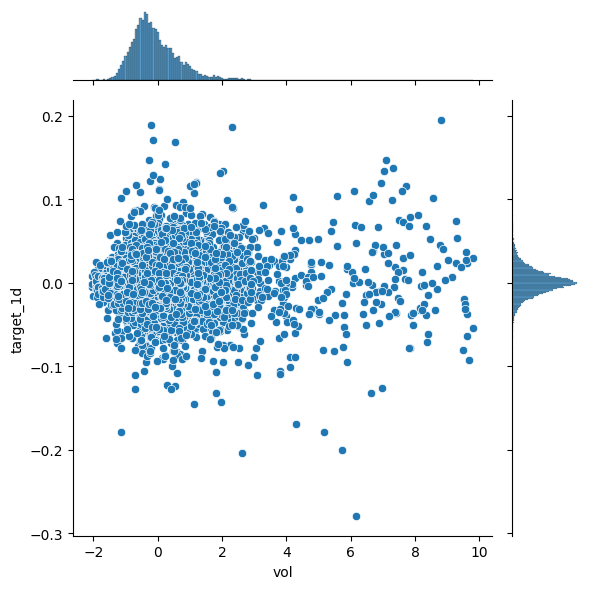

In [47]:
target = "target_1d"
metric = "vol"
j = sns.jointplot(x=metric, y=target, data=prices)
plt.tight_layout()

Calculate and display the Spearman rank correlation and p-value

In [48]:
df = prices[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
display(f"{r:,.2%} ({p:.2%})")

'0.82% (24.83%)'

Display the first 10 rows of 'prices' DataFrame for the symbol "TCS"

In [50]:
d = prices.loc["TCS.NS"].head(10)
display(d)

,high,low,close,volume,vol,return_1d,return_5d,return_10d,return_21d,return_42d,return_63d,target_1d,target_5d,target_10d,target_21d,target_42d,target_63d
date,,,,,,,,,,,,,,,,,
2015-01-20,1265.000000,1241.625000,1250.224976,2058566.0,0.090269,NaN,NaN,NaN,NaN,NaN,NaN,0.005339,0.015657,0.005539,0.070027,0.036333,-0.000100
2015-01-21,1261.000000,1244.125000,1256.900024,2310480.0,0.107312,0.005339,NaN,NaN,NaN,NaN,NaN,-0.000099,0.012272,0.015355,0.072738,0.023848,-0.007479
2015-01-22,1260.625000,1247.750000,1256.775024,2113214.0,0.076389,-0.000099,NaN,NaN,NaN,NaN,NaN,-0.003959,-0.012532,0.024746,0.076068,-0.000179,-0.010443
2015-01-23,1266.025024,1248.050049,1251.800049,3150380.0,-0.072302,-0.003959,NaN,NaN,NaN,NaN,NaN,-0.000619,0.004234,0.003715,0.067343,0.004474,-0.015937
2015-01-27,1257.500000,1244.775024,1251.025024,2738736.0,-0.360568,-0.000619,NaN,NaN,NaN,NaN,NaN,0.015008,0.022462,-0.024340,0.061709,0.024820,-0.008193
2015-01-28,1272.449951,1251.449951,1269.800049,3121980.0,-0.515314,0.015008,0.015657,NaN,NaN,NaN,NaN,0.001988,-0.009962,-0.031383,0.048334,0.005650,-0.008564
2015-01-29,1284.349976,1256.449951,1272.324951,3734392.0,-0.422612,0.001988,0.012272,NaN,NaN,NaN,NaN,-0.024601,0.003046,-0.032421,0.049024,-0.000786,-0.032067
2015-01-30,1287.500000,1235.000000,1241.025024,5817402.0,-0.185614,-0.024601,-0.012532,NaN,NaN,NaN,NaN,0.012953,0.037751,0.022844,0.118430,0.026289,0.025463
2015-02-02,1260.724976,1231.025024,1257.099976,3181802.0,-0.136703,0.012953,0.004234,NaN,NaN,NaN,NaN,0.017521,-0.000517,0.028081,0.092196,0.028160,0.005191


Display the metric and target columns

In [51]:
display(df[metric])
display(df[target])

symbol       date      
AXISBANK.NS  2015-01-20   -0.150210
             2015-01-21   -0.120454
             2015-01-22   -0.091616
             2015-01-23   -0.020156
             2015-01-27    0.123298
                             ...   
WIPRO.NS     2025-02-04    0.764552
             2025-02-05    0.664299
             2025-02-06    0.685052
             2025-02-07    0.607204
             2025-02-10    0.540717
Name: vol, Length: 19869, dtype: float64

symbol       date      
AXISBANK.NS  2015-01-20   -0.007526
             2015-01-21    0.031978
             2015-01-22    0.000708
             2015-01-23    0.047686
             2015-01-27   -0.002533
                             ...   
WIPRO.NS     2025-02-04    0.002688
             2025-02-05    0.002681
             2025-02-06    0.000157
             2025-02-07    0.003302
             2025-02-10   -0.018963
Name: target_1d, Length: 19869, dtype: float64

Display the correlation and p-value

In [52]:
display(r, p)

0.008191157516057722

0.24827420988749